# Natural Language Processing with Disater Tweets (now X)

- URL: https://www.kaggle.com/competitions/nlp-getting-started/overview

# Project Description

Twitter, now known as X, is a real-time tool to observe emergencies with eye-witness accounts. The social media platform is an important communication outlet in today's times and even more important in times of emergency because of the immediate repsonse to people tweeting their observations. On the flip side however, Twitter also has a diverse group of user's and there are times where dialect, slang, or regional variations in language that leads to unambigous disater identifcation. We would need to differentiate between a metaphorical disater and real disaters, so that it can be utilized as a tool for quicker response time for emergency personel or quicker depolyment time for unexpected/ unprecidented disasters

The dataset used in this project contains 10,000 tweets and we will utilize natural language processing to train a model to detemine/ predict which tweets are true natural disasters and which are not. 

# Evaluation
For the competition, I submit the evaluated F1 between the predicted and expected answers

Formula:
$ F_1 = 2 * \frac{precision * recall}{precision + recall} $

Precision:
$precision = \frac{TP}{TP + FP}$

Recall:
$recall = \frac{TP}{TP + FN}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from wordcloud import STOPWORDS
from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)



[nltk_data] Downloading package punkt to /Users/shawn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Description

In [2]:
# data is downloaded from kaggle competion url above

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(f"Training Set: {df_train.shape}")
print(f"Test Set: {df_test.shape}")

training_memory = df_train.memory_usage().sum() / 1024**2
test_memory = df_test.memory_usage().sum() / 1024**2
#Check Memory
print(f"Training Memory:{training_memory :.2f} MB")
print(f"Test Memory: {test_memory:.2f} MB")



Training Set: (7613, 5)
Test Set: (3263, 4)
Training Memory:0.29 MB
Test Memory: 0.10 MB


In [3]:
print(df_train.dtypes)

print(df_test.dtypes)


id           int64
keyword     object
location    object
text        object
target       int64
dtype: object
id           int64
keyword     object
location    object
text        object
dtype: object


- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
train_null_values = df_train.isnull().sum()
test_null_values = df_test.isnull().sum()

print("Train Null")
print(train_null_values)
print("Test Null")
print(test_null_values)

Train Null
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test Null
id             0
keyword       26
location    1105
text           0
dtype: int64


There are two columns that have nulls from both test and train data. Keyword and Location and will fill with "no_keyword" and "no_location" respectivly

In [5]:
print(df_train['keyword'].nunique())
print(df_test['keyword'].nunique())

print(df_train['location'].nunique())
print(df_test['location'].nunique())


221
221
3341
1602


In [6]:
for df in [df_train, df_test]:
    for column in ['keyword', 'location']:
        df[column] = df[column].fillna(f'no_{column}')


In [7]:
df_train

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1


In [8]:
df_test

,id,keyword,location,text
0,0,no_keyword,no_location,Just happened a terrible car crash
1,2,no_keyword,no_location,"Heard about #earthquake is different cities, s..."
2,3,no_keyword,no_location,"there is a forest fire at spot pond, geese are..."
3,9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires
4,11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,no_keyword,no_location,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,no_keyword,no_location,Storm in RI worse than last hurricane. My city...
3260,10868,no_keyword,no_location,Green Line derailment in Chicago http://t.co/U...
3261,10874,no_keyword,no_location,MEG issues Hazardous Weather Outlook (HWO) htt...


In [9]:
# Visualize target Mean
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

df_train


,id,keyword,location,text,target,target_mean
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,0.688525
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,0.688525
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,0.688525
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,0.688525
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,0.688525
...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,0.688525
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,0.688525
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.688525
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,0.688525


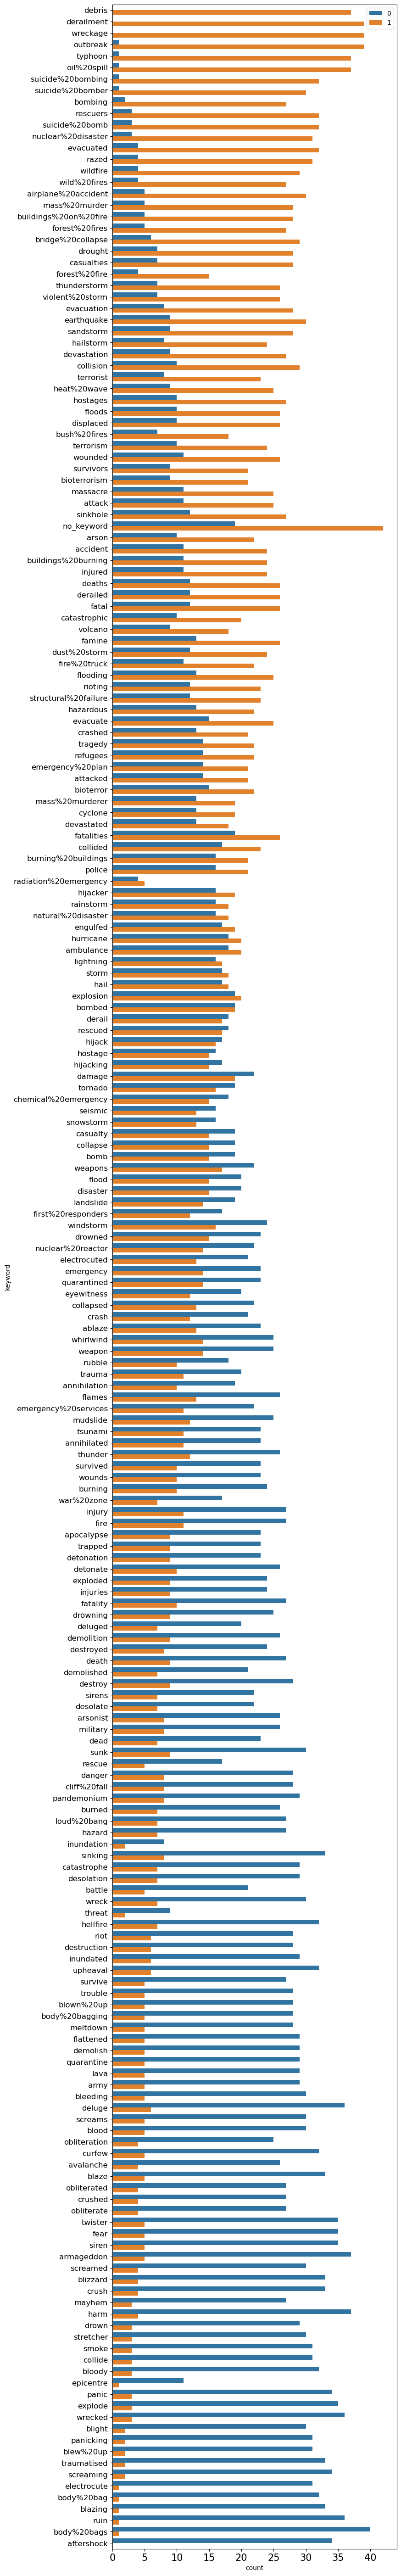

In [10]:
fig = plt.figure(figsize=(8,72))

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue = df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)

plt.show()

# EDA and ETL 

**Have to generate these features to better analyze text data. We will then use this data to begin the data cleaning process by identifying key features from the text** 
- word_count -> number of words in text
- unique_word_count -> number of unique words in text

- stop_word_count -> number of stop words in text
    - "Stop words are generally thought to be a “single set of words”. It really can mean different things to different applications. For example, in some applications removing all stop words right from determiners (e.g. the, a, an) to prepositions (e.g. above, across, before) to some adjectives (e.g. good, nice) can be an appropriate stop word list."
- url_count -> number of urls in text
- mean_word_length -> average character count in words
- char_count -> number of characters in text
- punctuation_count -> number of punctuations in text
- hashtag_count -> number of hashtags (#) in text
- mention_count  -> number of mentions (@) in text

In [11]:
# Get word count from each sentence
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
#Character Counts
df_train['character_count']= df_train['text'].apply(lambda x: len(str(x)))
df_test['character_count']= df_test['text'].apply(lambda x: len(str(x)))
# unique_word_count -> use a set to get unique values
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# Punctuations 
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


In [12]:
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [13]:
df_train

,id,keyword,location,text,target,target_mean,word_count,character_count,unique_word_count,punctuation_count,stop_word_count
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,0.688525,13,69,13,1,6
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,0.688525,7,38,7,1,0
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,0.688525,22,133,20,3,11
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,0.688525,8,65,8,2,1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,0.688525,16,88,15,2,7
...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,0.688525,11,83,11,5,2
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,0.688525,20,125,17,5,9
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.688525,8,65,8,11,1
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,0.688525,19,137,19,5,5


In [14]:
# Count url 
df_train['url_count'] = df_train['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# Count url 
df_test['url_count'] = df_test['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# Mean of word leghts 
df_train['mean_word_lenght'] = df_train['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))
# Mean of word leghts 
df_test['mean_word_lenght'] = df_test['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))

#Hashtag counts
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([hasht for hasht in str(x) if hasht =='#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([hasht for hasht in str(x) if hasht =='#']))

#mentions Count

df_train['mentions_count'] = df_train['text'].apply(lambda x: len([ment for ment in str(x) if ment =='@']))
df_test['mentions_count'] = df_test['text'].apply(lambda x: len([ment for ment in str(x) if ment =='@']))




## Plot the distribtions of the Training and Testing features

In [15]:
def feature_distributions_plots(df_train, df_test, metafeatures, disaster_tweets, figsize=(20, 50), dpi=100):
    """
    Plots feature distributions for training and test datasets, comparing disaster vs non-disaster tweets.

    Parameters:
    - df_train: DataFrame containing the training dataset.
    - df_test: DataFrame containing the test dataset.
    - metafeatures: List of features to plot.
    - disaster_tweets: Boolean Series or array to identify disaster tweets in df_train.
    - figsize: Tuple indicating figure size.
    - dpi: Dots per inch (resolution) of the figure.
    """
    # Creating subplots
    fig, axes = plt.subplots(ncols=2, nrows=len(metafeatures), figsize=figsize, dpi=dpi)

    for i, feature in enumerate(metafeatures):
        # Plotting non-disaster tweets
        sns.histplot(df_train.loc[~disaster_tweets][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
        # Plotting disaster tweets
        sns.histplot(df_train.loc[disaster_tweets][feature], label='Disaster', ax=axes[i][0], color='black', kde=True)

        # Plotting training set distribution
        sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
        # Plotting test set distribution
        sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)

        # Setting up the axes
        for j in range(2):
            axes[i][j].set_xlabel('')
            axes[i][j].tick_params(axis='x', labelsize=12)
            axes[i][j].tick_params(axis='y', labelsize=12)
            axes[i][j].legend()

        # Setting titles
        axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
        axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

    plt.tight_layout()
    plt.show()

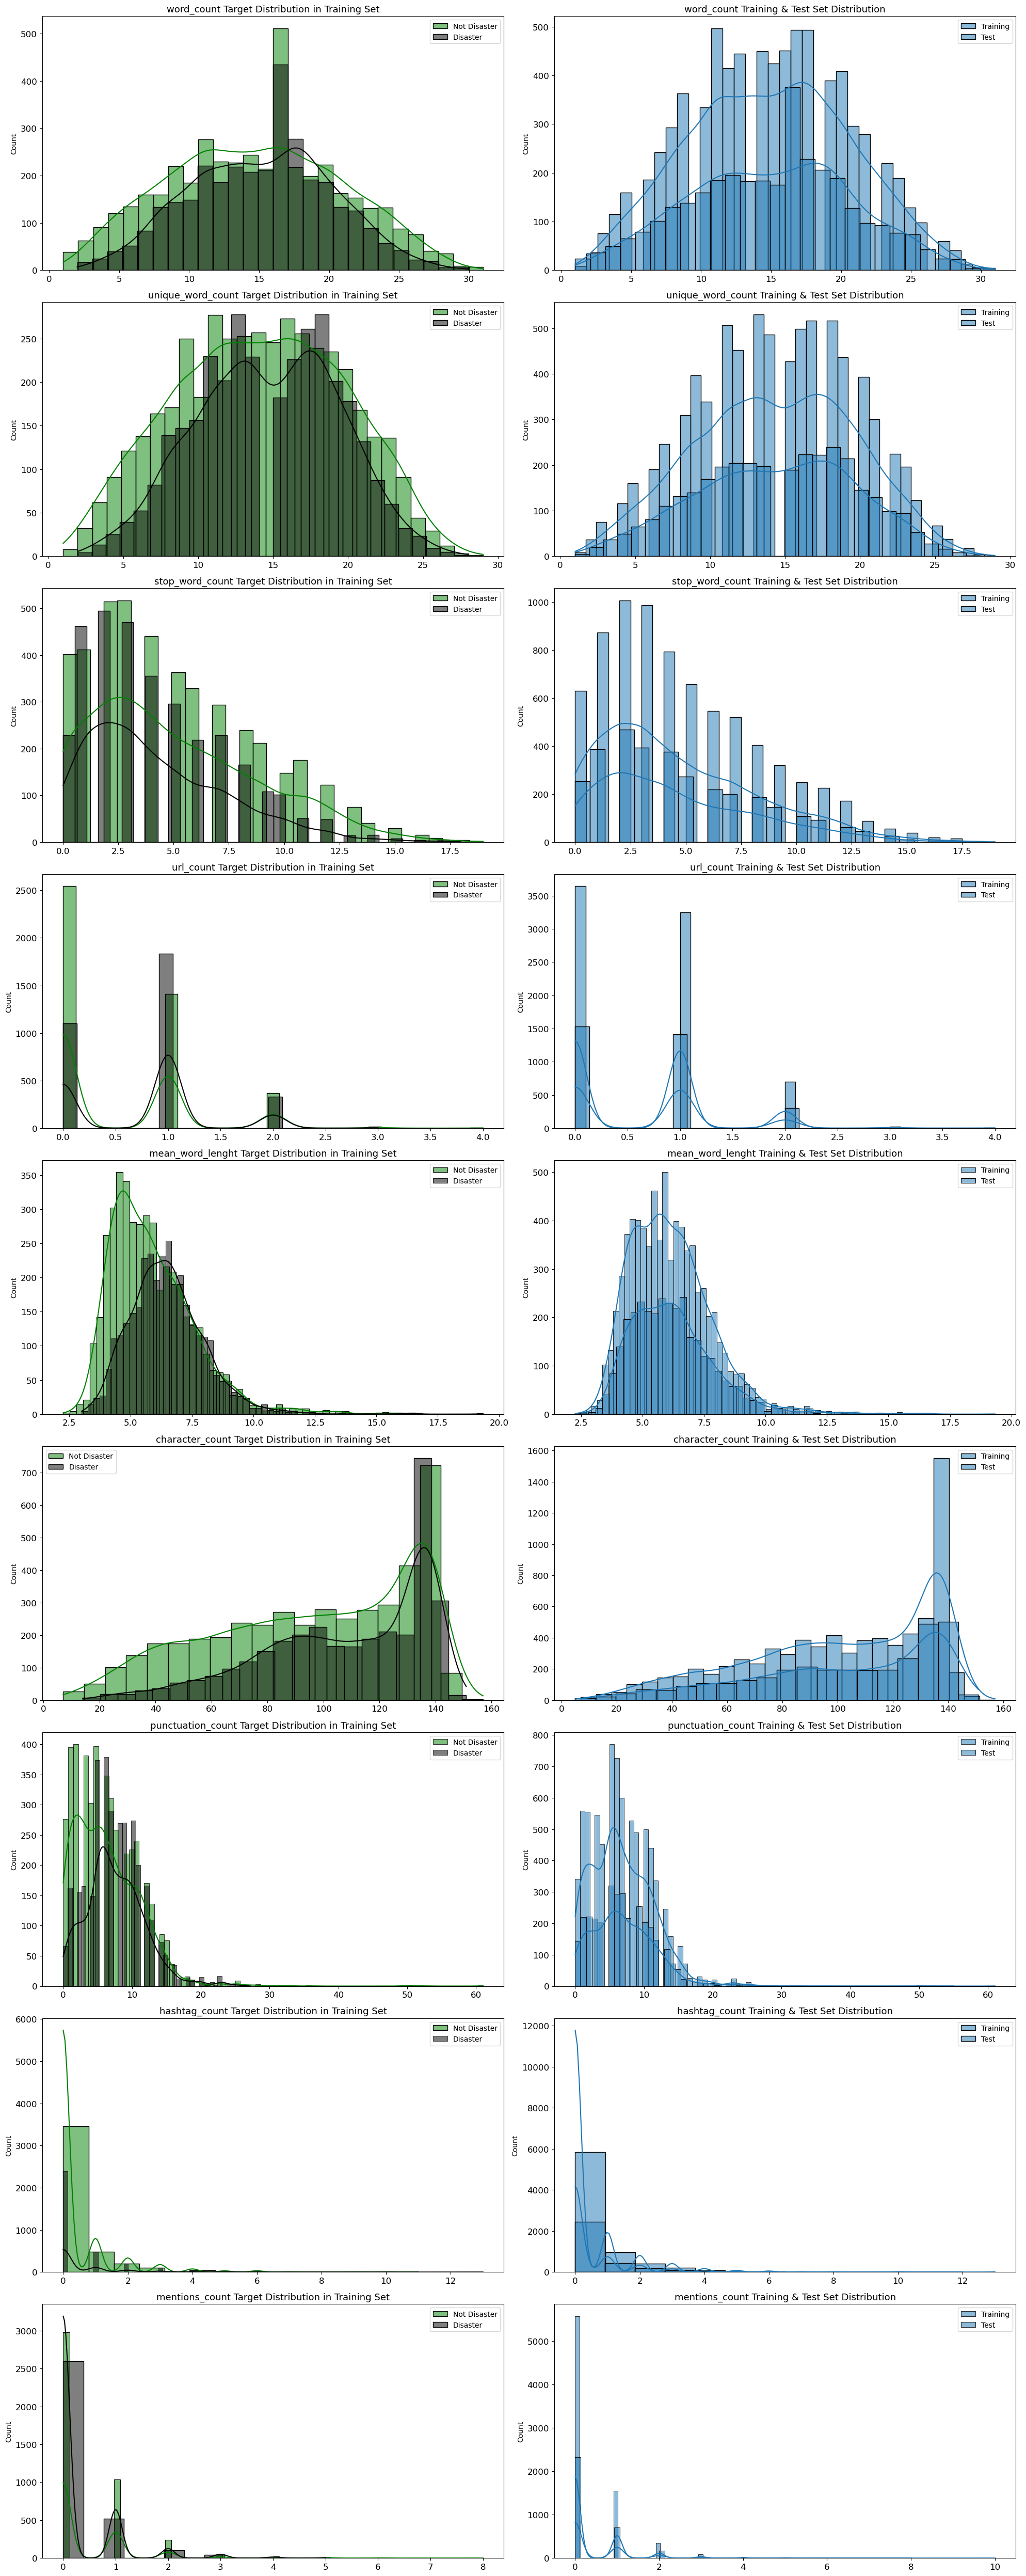

In [16]:
meta_features = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_lenght',
                'character_count', 'punctuation_count', 'hashtag_count', 'mentions_count']

disaster_tweets = df_train['target'] == 1

feature_distributions_plots(df_train, df_test, meta_features,disaster_tweets)

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

## N - Grams
- N-grams are continuous sequences of words or symbols, or tokens in a document. In technical terms, they can be defined as the neighboring sequences of items in a document. They come into play when we deal with text data in NLP (Natural Language Processing) tasks. They have a wide range of applications, like language models, semantic features, spelling correction, machine translation, text mining, etc.

<AxesSubplot:>

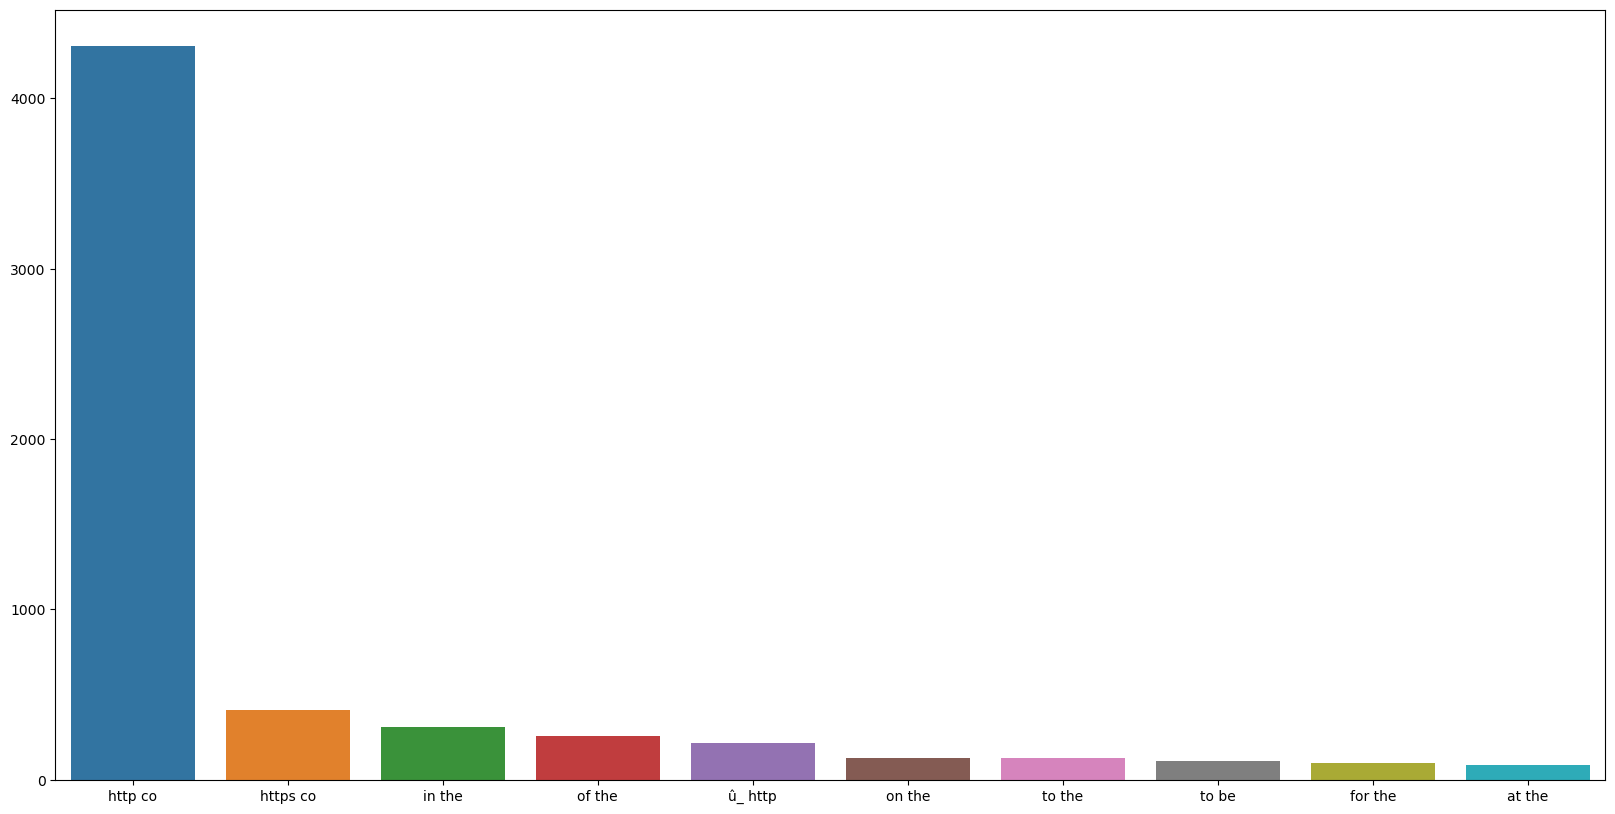

In [17]:
vector = CountVectorizer(ngram_range=(2,2)).fit(df_train['text'])
bag_of_words = vector.transform(df_train['text'])

word_sum = bag_of_words.sum(axis = 0)
frequency = [(word, word_sum[0,idx]) for word, idx in vector.vocabulary_.items()]

sort_frequency = sorted(frequency, key=lambda x:x[1], reverse=True)
top_10_tweets = sort_frequency[:10]

plt.figure(figsize=(20,10))
x,y = map(list,zip(*top_10_tweets))
sns.barplot(x=x,y=y)
# twitter_bigram = 

## Data Cleaning

#### Cleaning techniques for this dataset
- spelling correction
- remove punctuations
- remove html tags and any emojis


In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


In [19]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text



def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)


spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [20]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords
stemmer = nltk.SnowballStemmer("english")


[nltk_data] Downloading package stopwords to /Users/shawn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
df_train['cleaned_text']= df_train['text'].apply(clean_text)

df_test['cleaned_text']= df_test['text'].apply(clean_text)


In [22]:
df_train.sample(20)

,id,keyword,location,text,target,target_mean,word_count,character_count,unique_word_count,punctuation_count,stop_word_count,url_count,mean_word_lenght,hashtag_count,mentions_count,cleaned_text
464,671,attack,no_location,I'm not gonna lie I'm kinda ready to attack my...,0,0.694444,13,69,12,12,5,0,4.384615,0,0,im not gonna lie im kinda ready to attack my s...
7175,10283,war%20zone,ca(NADA),THIS IS A ONE DIRECTION CONCERT NOT A WAR ZONE...,1,0.291667,15,95,12,6,8,1,5.400000,1,0,this is a one direction concert not a war zone...
5668,8088,rescue,no_location,@LisaVanderpump How many dogs do you have and ...,0,0.227273,13,71,13,2,8,0,4.538462,0,1,lisavanderpump how many dogs do you have and a...
6656,9539,terrorist,MAD as Hell,RT AbbsWinston: #Zionist #Terrorist kidnapped ...,1,0.741935,15,133,15,10,2,1,7.933333,3,0,rt abbswinston zionist terrorist kidnapped pa...
5425,7743,panicking,Positive 852,My sis can now sit on a cam w/o panicking http...,0,0.060606,11,65,11,6,4,1,5.000000,0,0,my sis can now sit on a cam wo panicking
3226,4630,emergency%20services,"Whippany, NJ",Air Group is here to the rescue! We have 24/7 ...,0,0.333333,20,137,19,14,10,2,5.900000,0,0,air group is here to the rescue we have emerg...
5394,7695,panicking,Detroit,Have to laughtraders panicking over market dow...,0,0.060606,23,132,22,5,12,0,4.782609,0,0,have to laughtraders panicking over market dow...
4879,6948,massacre,Minneapolis - St. Paul,UK police link Tunisian beach massacre with Ba...,1,0.694444,11,86,11,5,1,1,6.909091,0,0,uk police link tunisian beach massacre with ba...
5441,7761,police,no_location,Police expand search for missing pregnant woma...,0,0.567568,16,136,14,11,4,1,7.562500,0,0,police expand search for missing pregnant woma...
49,71,ablaze,England.,First night with retainers in. It's quite weir...,0,0.361111,27,138,25,5,11,0,4.148148,0,0,first night with retainers in its quite weird ...


# Modeling 

I am going to use a LSTM model for this project

In [23]:
word_tokenizer = Tokenizer()


In [24]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [25]:
tweets = df_train['cleaned_text'].values
disaster_tweet = df_train['target'].values
test_tweets = df_test['cleaned_text'].values

word_tokenizer.fit_on_texts(tweets)
vocabulary_length = len(word_tokenizer.word_index) + 1

- Tokenization - the processing of segmenting text into sentences of words.
- We throw away punctuation and extra symbols too. 
- The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers,
which can actually be used for processing

In [26]:
# Adding Padding
longest_tweet_train = max(tweets,key=lambda sentence: len(word_tokenize(sentence)))
print(longest_tweet_train)

length_of_longest_tweet = len(word_tokenize(longest_tweet_train))
print(length_of_longest_tweet)

train_padded_sentence = pad_sequences(embed(tweets), length_of_longest_tweet, padding='post')

test_padded_sentences = pad_sequences(embed(test_tweets), length_of_longest_tweet, padding='post')

if you have a son or a daughter would you like to see them going to a war with iran and come back in a body bag let the republicans know
31


Using GloVe ( Global Vectors for Word Replication) we get a vector representation that focuses on words co-occurrences over the whole copus. It has embeddings relate to the probabilities that two words appear together

- https://github.com/stanfordnlp/GloVe?tab=readme-ov-file

In [27]:
embedding_dictionary = dict()
dimension = 100

glove_file = open('gloVe/glove.6B.100d.txt')

for line in glove_file:
    record = line.split()
    word = record[0]
    vector_dimension = np.asarray(record[1:], dtype='float32')

    embedding_dictionary[word] = vector_dimension
glove_file.close()

In [28]:
embedding_matrix = np.zeros((vocabulary_length, dimension))

for w, index in word_tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(w)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [29]:
# Split training data in Train/Test set

X_train, X_test, y_train, y_test = train_test_split(train_padded_sentence, disaster_tweet, test_size=0.25)

# Model

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [30]:
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                    output_dim=embedding_matrix.shape[1], 
                    weights = [embedding_matrix], 
                    input_length=length_of_longest_tweet))
model.add(Bidirectional(LSTM(length_of_longest_tweet, return_sequences = True, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(length_of_longest_tweet, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(length_of_longest_tweet, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model_checkpoint = ModelCheckpoint('model/model.h5', monitor='val_loss',verbose=1, save_best_only=True)

reduce_learningRate = ReduceLROnPlateau(monitor='val_loss',factor=0.2, verbose=1, patience=5, min_lr=0.001)

In [32]:
model_fit = model.fit(X_train, y_train, epochs=10, batch_size=35, validation_data=[X_test,y_test],verbose=1, callbacks=[model_checkpoint, reduce_learningRate])

Epoch 1/10
164/164 [==============================] - ETA: 0s - loss: 0.7228 - accuracy: 0.6094
Epoch 1: val_loss improved from inf to 0.62198, saving model to model/model.h5
164/164 [==============================] - 8s 33ms/step - loss: 0.7228 - accuracy: 0.6094 - val_loss: 0.6220 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 2/10
163/164 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.7167
Epoch 2: val_loss improved from 0.62198 to 0.51099, saving model to model/model.h5
164/164 [==============================] - 6s 35ms/step - loss: 0.5743 - accuracy: 0.7166 - val_loss: 0.5110 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 3/10
164/164 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7674
Epoch 3: val_loss improved from 0.51099 to 0.44022, saving model to model/model.h5
164/164 [==============================] - 5s 33ms/step - loss: 0.5175 - accuracy: 0.7674 - val_loss: 0.4402 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 4/10
164/164 [============

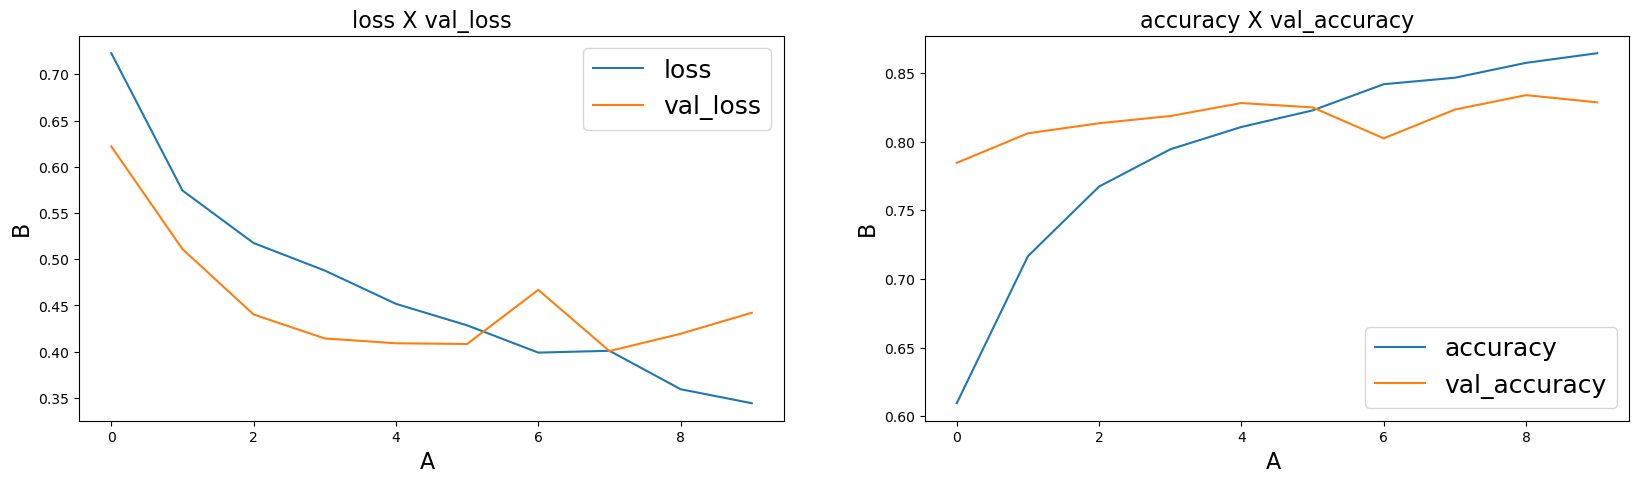

In [33]:
plot(model_fit, [['loss','val_loss'],['accuracy','val_accuracy']])

In [34]:
model.load_weights('model/model.h5')
predictions = model.predict(X_test).round()

y_test

metrics(predictions,y_test)

60/60 [==============================] - 1s 7ms/step
F1-score:  0.7600000000000001
Precision:  0.6708701134930644
Recall:  0.8764415156507414
Acuracy:  0.8235294117647058
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      1297
         1.0       0.67      0.88      0.76       607

    accuracy                           0.82      1904
   macro avg       0.80      0.84      0.81      1904
weighted avg       0.85      0.82      0.83      1904



# Submission File

In [35]:
submission = pd.read_csv('data/sample_submission.csv')
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [36]:
submission['target'] = model.predict(test_padded_sentences).round()
submission


102/102 [==============================] - 1s 8ms/step


,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,1.0


In [37]:
submission['target'] = submission['target'].astype('int')

<AxesSubplot:>

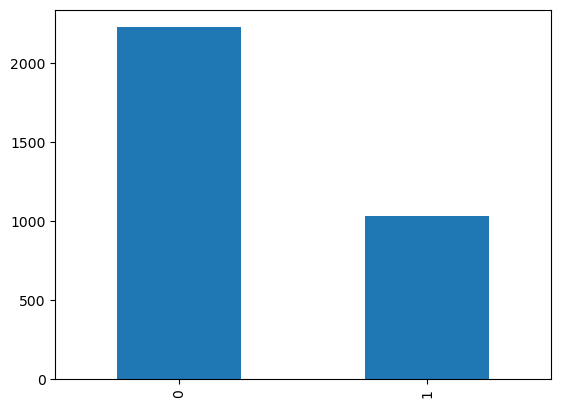

In [39]:
submission['target'].value_counts().plot.bar()

In [40]:
submission.to_csv('submission.csv',index=False)


# Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways.
What did and did not help improve the performance of your models? 
What improvements could you try in the future?

# Resources
- N- Grams: https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/#:~:text=N%2Dgrams%20are%20continuous%20sequences,of%20items%20in%20a%20document.
- NLP and BERT Tutorial-
https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
- NLP Getting Started- https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- https://www.databricks.com/sites/default/files/2023-03/big-book-of-data-science-2ndedition.pdf
- https://kavita-ganesan.com/what-are-stop-words/
- https://arxiv.org/pdf/2111.01243.pdf
- https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial
- Tokenization: https://www.youtube.com/watch?v=fNxaJsNG3-s&ab_channel=TensorFlow
- https://nlp.stanford.edu/pubs/glove.pdf